In [145]:
import os

from scipy.stats import ttest_ind
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pyometiff
import pandas as pd
import seaborn as sns
from google.colab import drive

In [146]:
PATH_TO_FOLDER = os.path.join('..', 'd4l')
TRAIN_DATA_PATH = os.path.join(PATH_TO_FOLDER, 'train')
# ORIGINAL_IMAGE_DATA_SUBDIR = 'images_masks'
# ORIGINAL_MASKS_SUBDIR = 'masks'
# ORIGINAL_IMAGES_SUBDIR = 'img'

drive.mount('/content/drive')
PATH_TO_FOLDER = '/content/drive/My drive/MAGISTERKA/DL'
TRAIN_DATA_PATH = os.path.join(PATH_TO_FOLDER, 'train')


if PATH_TO_FOLDER is None:
    raise ValueError('Please set PATH_TO_FOLDER to a path with unzipped training data.')

ANNDATA_PATH = 'cell_data.h5ad'
TRAIN_ANNDATA_PATH = os.path.join(TRAIN_DATA_PATH, ANNDATA_PATH)
# TRAIN_IMAGE_DATA_DIR = os.path.join(TRAIN_DATA_PATH, ORIGINAL_IMAGE_DATA_SUBDIR)
# TRAIN_IMAGE_DATA_IMAGES = os.path.join(TRAIN_IMAGE_DATA_DIR, ORIGINAL_IMAGES_SUBDIR)
# TRAIN_IMAGE_DATA_MASKS = os.path.join(TRAIN_IMAGE_DATA_DIR, ORIGINAL_MASKS_SUBDIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
PATH_TO_FOLDER = '/content/drive/My Drive/MAGISTERKA/DL'
TRAIN_DATA_PATH = os.path.join(PATH_TO_FOLDER, 'train')


if PATH_TO_FOLDER is None:
    raise ValueError('Please set PATH_TO_FOLDER to a path with unzipped training data.')

ANNDATA_PATH = 'cell_data.h5ad'
TRAIN_ANNDATA_PATH = os.path.join(TRAIN_DATA_PATH, ANNDATA_PATH)
# TRAIN_IMAGE_DATA_DIR = os.path.join(TRAIN_DATA_PATH, ORIGINAL_IMAGE_DATA_SUBDIR)
# TRAIN_IMAGE_DATA_IMAGES = os.path.join(TRAIN_IMAGE_DATA_DIR, ORIGINAL_IMAGES_SUBDIR)
# TRAIN_IMAGE_DATA_MASKS = os.path.join(TRAIN_IMAGE_DATA_DIR, ORIGINAL_MASKS_SUBDIR)

In [148]:
def normalize(expressions, scaling_factor=5):
    """
    Transform in CELESTA.ipynb

    Normalizes expression data using the arcsinh transformation.
    """
    expressions_transformed = np.arcsinh(expressions) / scaling_factor
    return expressions_transformed

def plot_marker_expressions(exp_df, markers):
    fig, axs = plt.subplots(len(markers), 1, figsize=(7, 5 * len(markers)))
    for i, gene in enumerate(markers):
        axs[i].hist(exp_df[gene], bins=100, color='r', alpha=0.5)
        axs[i].set_title(f'{gene} - Raw')
    plt.show()

def plot_cell_type_count(exp_df):
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    ax.hist(exp_df['celltypes'], bins=30, color='r', alpha=0.5)
    ax.set_title('Cell Type Count')
    plt.show()

def plot_marker_expression_range(exp_df, markers):
    """
    Plot the range of expression values for each marker gene. Scatter plot of the minimum and maximum expression values.
    """
    fig, axs = plt.subplots(len(markers), 1, figsize=(15, 5 * len(markers)))
    for i, marker in enumerate(markers):
        axs[i].scatter(exp_df['celltypes'], exp_df[marker], color='g', alpha=0.1)
        axs[i].set_title(f'{marker} - Expression Range')
    plt.show()

def plot_variance_of_markers(exp_df):
    """
    Plot the variance of each marker gene.
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.bar(exp_df.columns, exp_df.var(), color='b', alpha=0.5)
    ax.set_title('Variance of Marker Genes')
    ax.set_xticklabels(exp_df.columns, rotation=90)
    plt.show()

def analyze_marker_expressions(exp_df, all_data_df, p_value_threshold=0.01):
    cell_types = all_data_df['celltypes'].unique()
    markers = exp_df.columns
    result = {}
    subjects = all_data_df['sample_id'].unique()


    for cell_type in cell_types:
        lower_markers = []
        higher_markers = []
        for subject in subjects:
            lower = set()
            higher = set()
            subject_df = all_data_df[all_data_df['sample_id'] == subject]
            for marker in markers:
                cell_type_expr = subject_df[subject_df['celltypes'] == cell_type][marker]
                other_cell_types_expr = subject_df[subject_df['celltypes'] != cell_type][marker]

                t_stat, p_value = ttest_ind(cell_type_expr, other_cell_types_expr)
                if p_value < p_value_threshold:
                    if cell_type_expr.mean() < other_cell_types_expr.mean():
                        lower.add(marker)
                    else:
                        higher.add(marker)
            lower_markers.append(lower)
            higher_markers.append(higher)
        result[cell_type] = {'lower': lower_markers, 'higher': higher_markers}

    return result

def get_significant_markers(marker_dict, all_data_df, threshold=0.8):
    """
    Get the markers that are present in cell types in at least 80% of subjects.
    """
    num_of_subjects = len(all_data_df['sample_id'].unique())
    result_dict = {}
    for cell_type, markers_sets in marker_dict.items():
        result_dict[cell_type] = {'lower' : [], 'higher' : []}
        for markers_set in markers_sets['lower']:
            result_dict[cell_type]['lower'] += markers_set
        for markers_set in markers_sets['higher']:
            result_dict[cell_type]['higher'] += markers_set

        result_dict[cell_type]['lower'] = [marker for marker in set(result_dict[cell_type]['lower']) if result_dict[cell_type]['lower'].count(marker) / num_of_subjects >= threshold]
        result_dict[cell_type]['higher'] = [marker for marker in set(result_dict[cell_type]['higher']) if result_dict[cell_type]['higher'].count(marker) / num_of_subjects >= threshold]
    return result_dict

def make_table_with_significant_markers(significant_markers_dict):
    all_markers = set()

    cell_types = significant_markers_dict.keys()
    for cell_type, markers_dict in significant_markers_dict.items():
        all_markers.update(markers_dict['lower'])
        all_markers.update(markers_dict['higher'])
    marker_to_level_dict = {marker: [] for marker in all_markers}
    for cell_type, markers_dict in significant_markers_dict.items():
        for marker in all_markers:
            if marker in markers_dict['lower']:
                marker_to_level_dict[marker].append('lower')
            elif marker in markers_dict['higher']:
                marker_to_level_dict[marker].append('higher')
            else:
                marker_to_level_dict[marker].append('none')

    result_df = pd.DataFrame(marker_to_level_dict)
    result_df['celltype'] = cell_types
    result_df.set_index('celltype', inplace=True)

    return result_df

In [149]:
train_anndata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)

In [150]:
markers = train_anndata.var['marker']
expressions_df = pd.DataFrame(train_anndata.layers["exprs"], columns=markers)
all_data = pd.concat([train_anndata.obs.reset_index(), expressions_df], axis=1)

In [151]:
print("There is a total of", len(all_data), "cells in the dataset.")

There is a total of 236791 cells in the dataset.


In [152]:
print("Minimal expression value: ", np.min(expressions_df.values))
print("Maximal expression value: ", np.max(expressions_df.values))
print("Mean expression value: ", np.mean(expressions_df.values))
print("Median expression value: ", np.median(expressions_df.values))
print("Maximal standard deviation of expression values: ", np.max(np.std(expressions_df.values, axis=0)))
print("Minimal standard deviation of expression values: ", np.min(np.std(expressions_df.values, axis=0)))

Minimal expression value:  0.0
Maximal expression value:  8.436070526198012
Mean expression value:  1.347737665027196
Median expression value:  0.914181447627153
Maximal standard deviation of expression values:  1.4945013816311672
Minimal standard deviation of expression values:  0.28289971656300267


There are only non-negative marker expression values.

The 'distToCells' column is the only one containing NaN values, with a total of 11829 NaN entries.

In [153]:
all_data['distToCells'].isnull().sum()

11829

# General data overview

The dataset provided includes spatial information at the individual cell level. It includes X and Y coordinates, along with marker levels acquired through the IMC method, as well as cell types.

In [154]:
print(f"Dataset has {len(all_data['image'].unique())} tissue images from {len(all_data['sample_id'].unique())} unique subjects.")
print(f"Dataset has {len(all_data['celltypes'].unique())} unique cell types:", ", ".join(list(all_data['celltypes'].unique())))
print(f"Each cell has {len(expressions_df.columns)} features (marker expressions):", ", ".join(list(expressions_df.columns)))

Dataset has 125 tissue images from 125 unique subjects.
Dataset has 15 unique cell types: MacCD163, Mural, DC, Tumor, CD4, HLADR, NK, CD8, Treg, Neutrophil, plasma, undefined, B, pDC, BnT
Each cell has 40 features (marker expressions): MPO, HistoneH3, SMA, CD16, CD38, HLADR, CD27, CD15, CD45RA, CD163, B2M, CD20, CD68, Ido1, CD3, LAG3, CD11c, PD1, PDGFRb, CD7, GrzB, PDL1, TCF7, CD45RO, FOXP3, ICOS, CD8a, CarbonicAnhydrase, CD33, Ki67, VISTA, CD40, CD4, CD14, Ecad, CD303, CD206, cleavedPARP, DNA1, DNA2


In [155]:
expressions_df.columns

Index(['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
       'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
       'CD11c', 'PD1', 'PDGFRb', 'CD7', 'GrzB', 'PDL1', 'TCF7', 'CD45RO',
       'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
       'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'cleavedPARP', 'DNA1',
       'DNA2'],
      dtype='object', name='marker')


Below we present distribution of normalized data for a couple of markers.

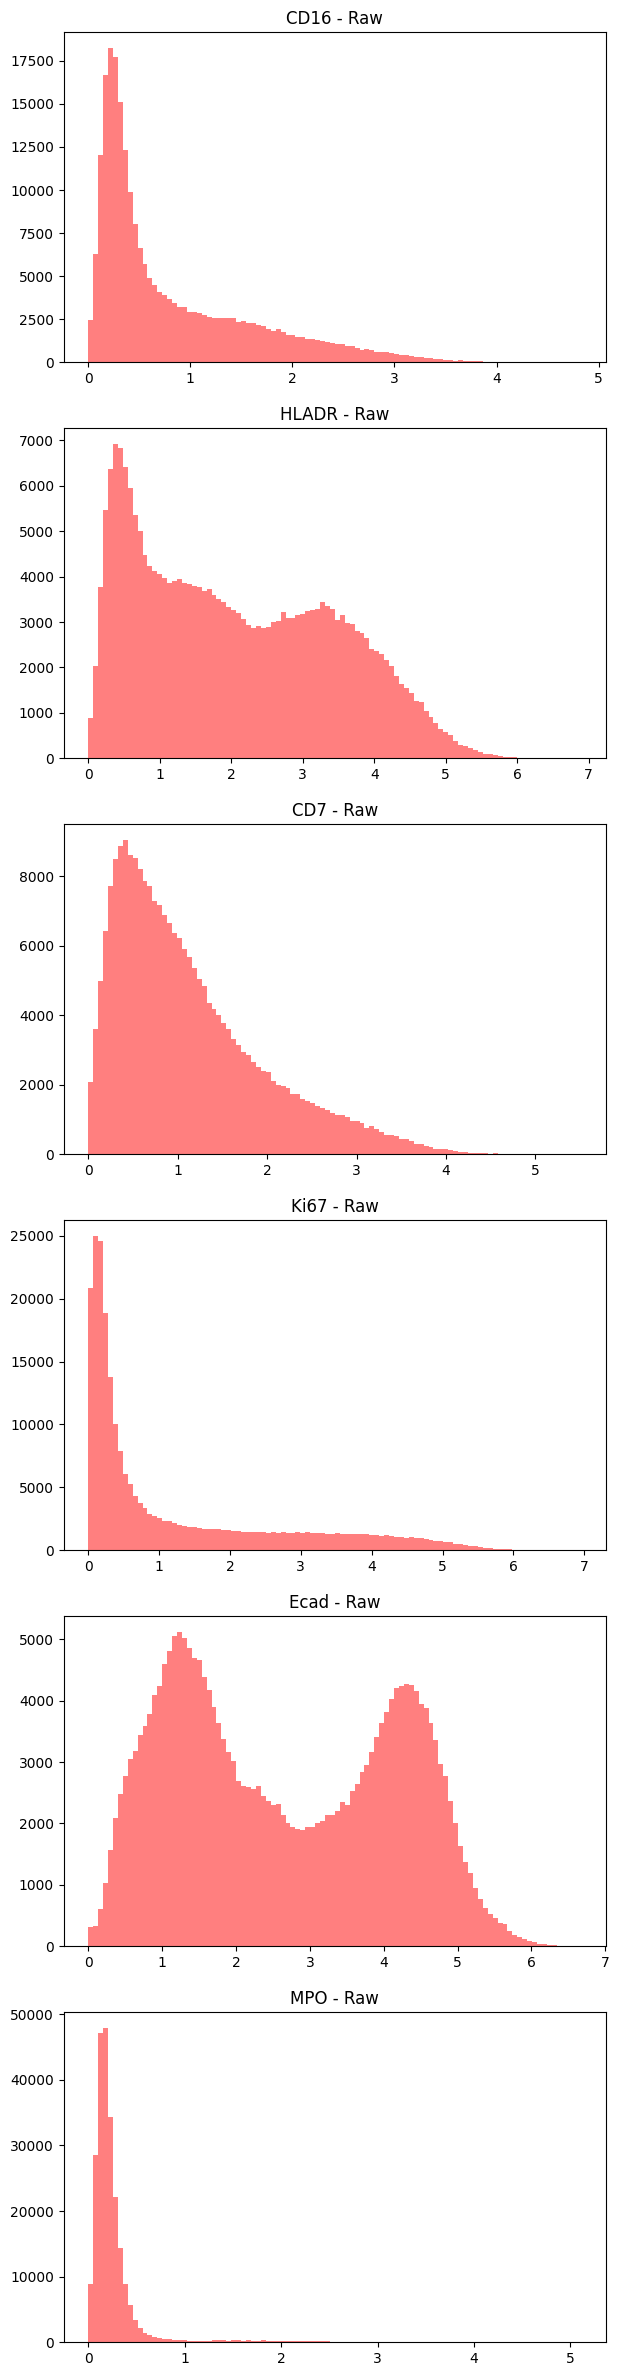

In [156]:
plot_marker_expressions(expressions_df, ['CD16', 'HLADR', 'CD7', 'Ki67', 'Ecad','MPO'])

Some markers display a bimodal distribution, featuring two distinct expression peaks. Others showcase a unimodal distribution with a narrower range of expression values across all cells, or a prominent single peak with the remaining values appearing relatively uniform. Additionally, some markers exhibit a somewhat normal distribution but may be skewed.

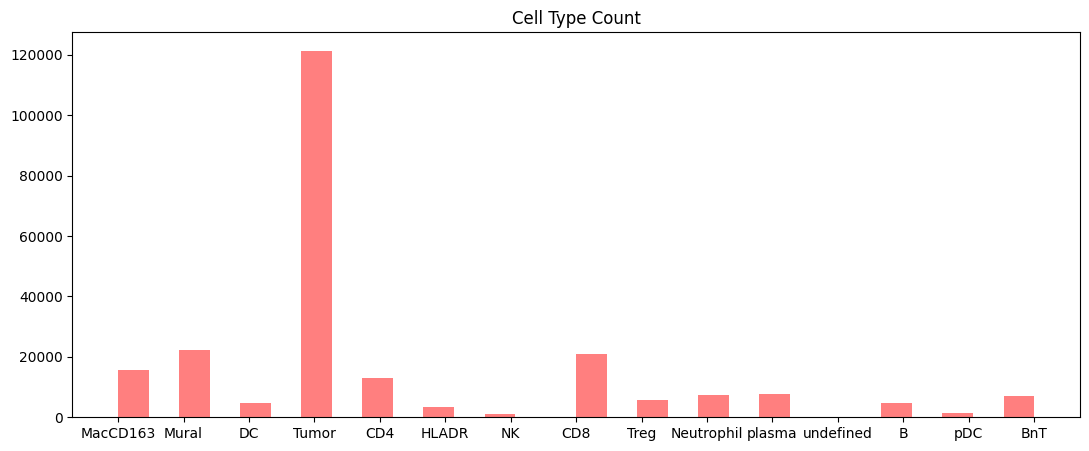

In [157]:
plot_cell_type_count(all_data)

As presented, there is a very significant prevalence of Tumor cells.

Markers exhibit varying levels across different cell types, and we illustrate these discrepancies for a selection of markers.

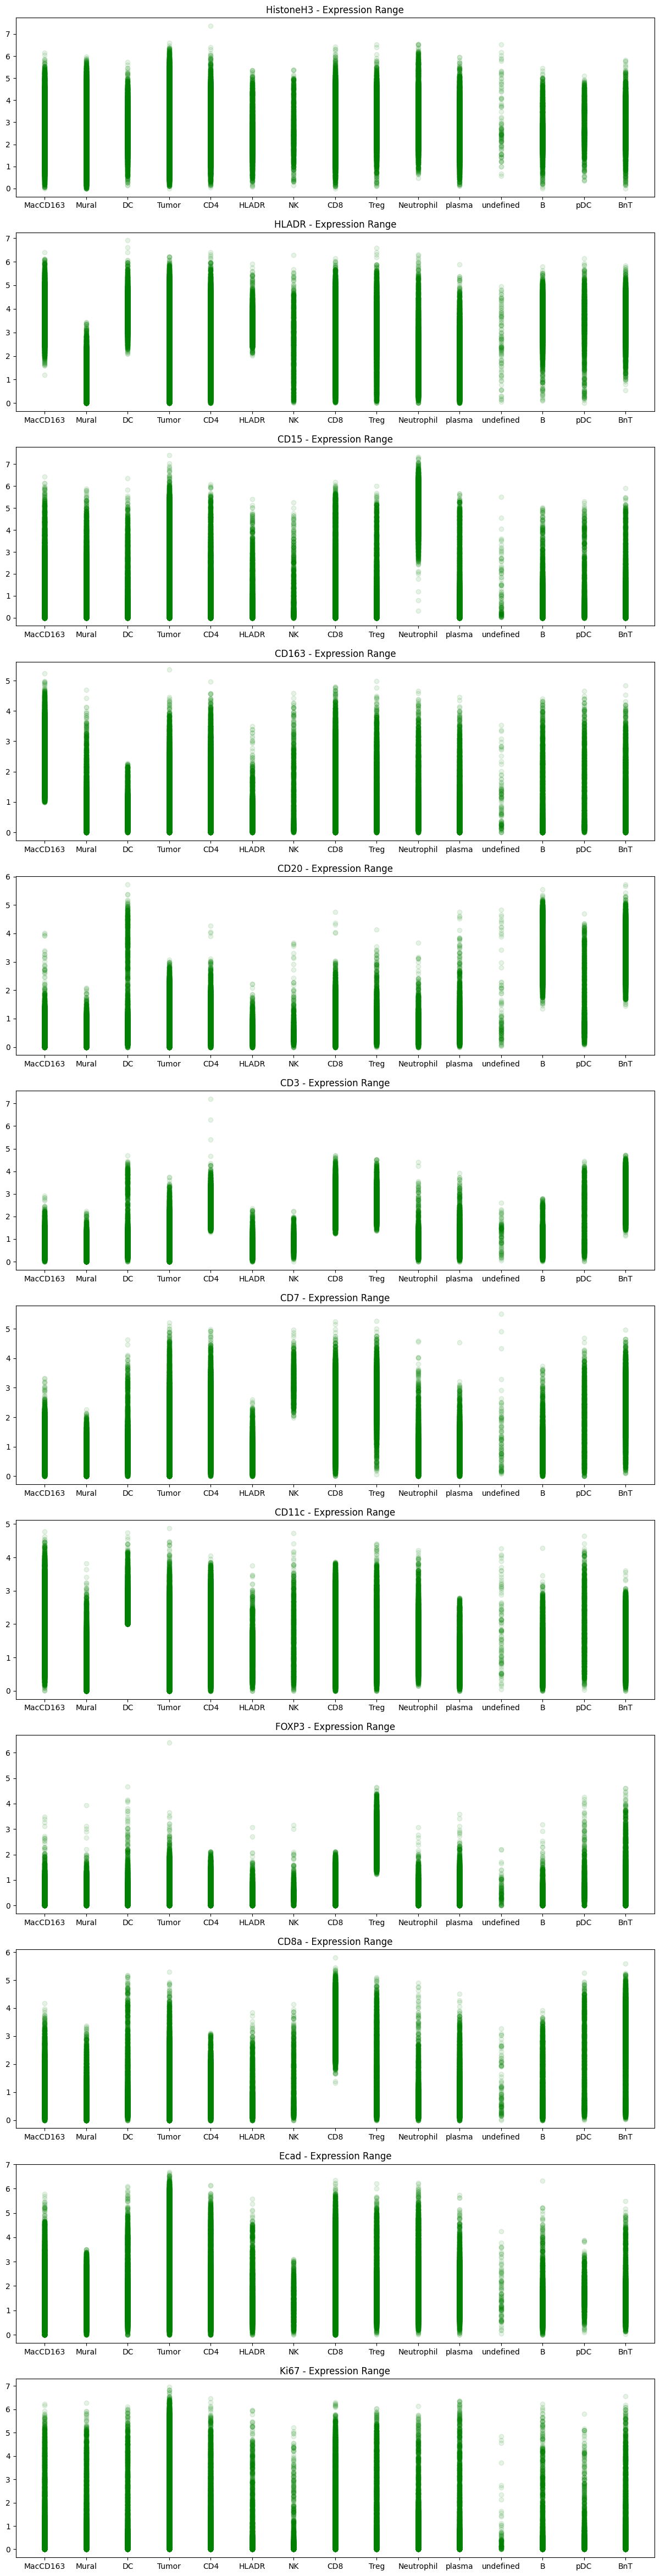

In [158]:
plot_marker_expression_range(all_data, ['HistoneH3', 'HLADR', 'CD15', 'CD163', 'CD20', 'CD3', 'CD7', 'CD11c', 'FOXP3', 'CD8a', 'Ecad', 'Ki67'])

<ipython-input-148-1583d3c73cee>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(exp_df.columns, rotation=90)


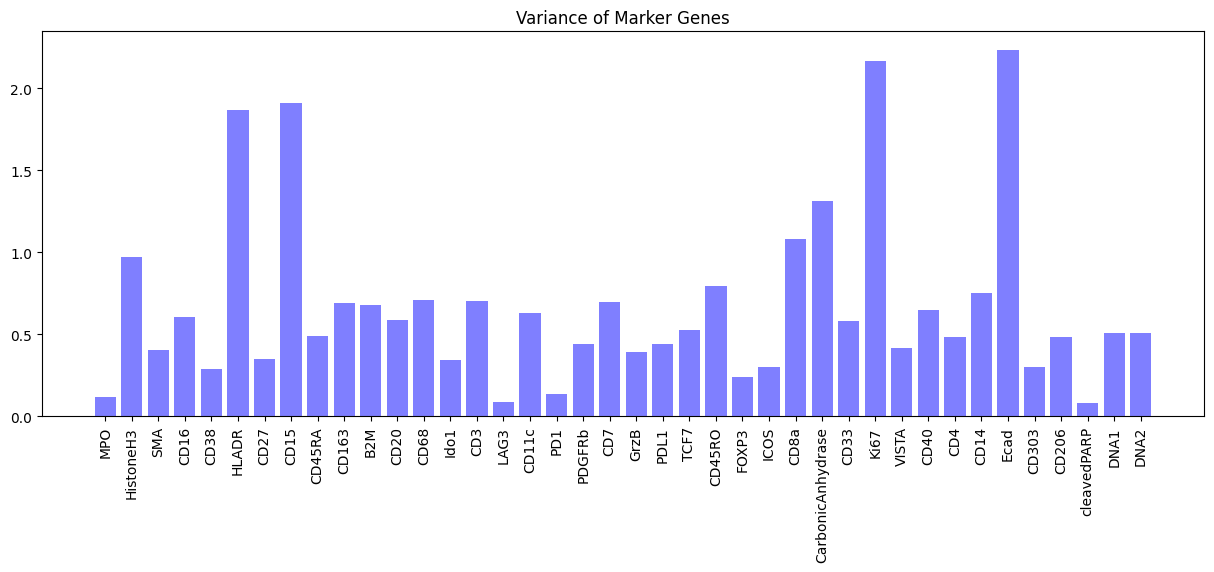

In [159]:
plot_variance_of_markers(expressions_df)

In [160]:
marker_expressions_levels = analyze_marker_expressions(expressions_df, all_data, p_value_threshold=0.01)

In [161]:
significant_markers = get_significant_markers(marker_expressions_levels, all_data, threshold=0.8)

In [162]:
cell_types = all_data['celltypes'].unique()

In [163]:
'. '.join(list(cell_types))

'MacCD163. Mural. DC. Tumor. CD4. HLADR. NK. CD8. Treg. Neutrophil. plasma. undefined. B. pDC. BnT'

In [164]:
significant_markers['Tumor']

{'lower': ['CD163', 'CD16', 'CD68', 'SMA', 'PDGFRb', 'CD45RO'],
 'higher': ['CarbonicAnhydrase', 'Ecad']}

In [165]:
markers_signature_df = make_table_with_significant_markers(significant_markers)

In [166]:
MARKERS_RELATIVE_LEVELS_DF_FILE = 'markers_table.csv'
markers_signature_df = pd.read_csv(MARKERS_RELATIVE_LEVELS_DF_FILE)
markers_signature_df.rename(columns={'Unnamed: 0': 'celltype'}, inplace=True)
markers_signature_df.set_index('celltype', inplace=True)

In [167]:
markers_signature_df.head()

,CD68,CD163,CD14,CD11c,CD206,CD33,CD40,SMA,CD27,CD45RA,...,Ido1,LAG3,PD1,PDGFRb,PDL1,Ki67,cleavedPARP,B2M,CarbonicAnhydrase,VISTA
celltype,,,,,,,,,,,,,,,,,,,,,
B,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.5,1.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
Neutrophil,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
DC,0.0,0.0,0.0,1.0,0.5,0.0,1.0,0.0,0.0,0.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
HLADR,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,...,0.5,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
NK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


## Cell types and markers correlation

Our objective was to examine the markers exhibiting significantly higher or lower levels across all cell types. To achieve this, we conducted T-tests comparing the means of marker levels for a specific cell type against the means of marker levels for the remaining cell types. Additionally, T-tests were performed for each Region of Interest (ROI) individually to ensure that any differences in marker level distributions were not confounded by potential batch effects.

We set the significance threshold at a p-value of 0.01 and identified sets of markers that were significantly higher or lower for each ROI and each cell type. We considered the results reliable if a particular marker showed a significant difference in at least 80% of the ROI.

The results are documented in the 'markers_levels_in_cell_types.csv' file, and we highlight a selection of biologically intriguing findings below.

In [168]:
cell_types_subset = ['Tumor', 'Mural', 'DC', 'MacCD163', 'CD4', 'CD8']
markers_subset = ['HLADR', 'CD8a', 'HistoneH3', 'CD11c', 'CD4', 'PDGFRb', 'Ecad', 'CD3', 'ICOS']
sub_signature_df = markers_signature_df.loc[cell_types_subset, markers_subset]

In [169]:
sub_signature_df

,HLADR,CD8a,HistoneH3,CD11c,CD4,PDGFRb,Ecad,CD3,ICOS
celltype,,,,,,,,,
Tumor,0.0,0.0,1.0,0.0,0.0,0.5,1.0,0.0,0.0
Mural,0.5,0.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0
DC,1.0,0.0,1.0,1.0,0.0,0.5,0.0,0.0,0.5
MacCD163,1.0,0.0,1.0,1.0,0.5,0.5,0.0,0.0,0.0
CD4,0.5,0.0,1.0,0.0,1.0,0.5,0.0,1.0,0.5
CD8,0.5,1.0,1.0,0.0,0.0,0.5,0.0,1.0,0.0


## Biological explanation
* High expression of Ecan on Tumor cells

* High expression of HLADR on Macrophages and Dendritic cells

* High expression of CD11c on Dendritic cells

* High expression of CD4 in CD4 T cells

* Low expression of Histone H3 in Mural cells

* Low expression of ICOS in Mural cells

* High expression of SMA in Mural cells

* High expression of CD11c on Marcophages and Dentritic cells

* High expression of CD8a on CD8 T cells

* High expression of CD3 on T cells

* High expression of Carbonic Anhydrase in Tumor cells

* High expression of CD68 on Macrophages



## Co-expression of markers

In [171]:
markers_corr = expressions_df.corr()

<Axes: xlabel='marker', ylabel='marker'>

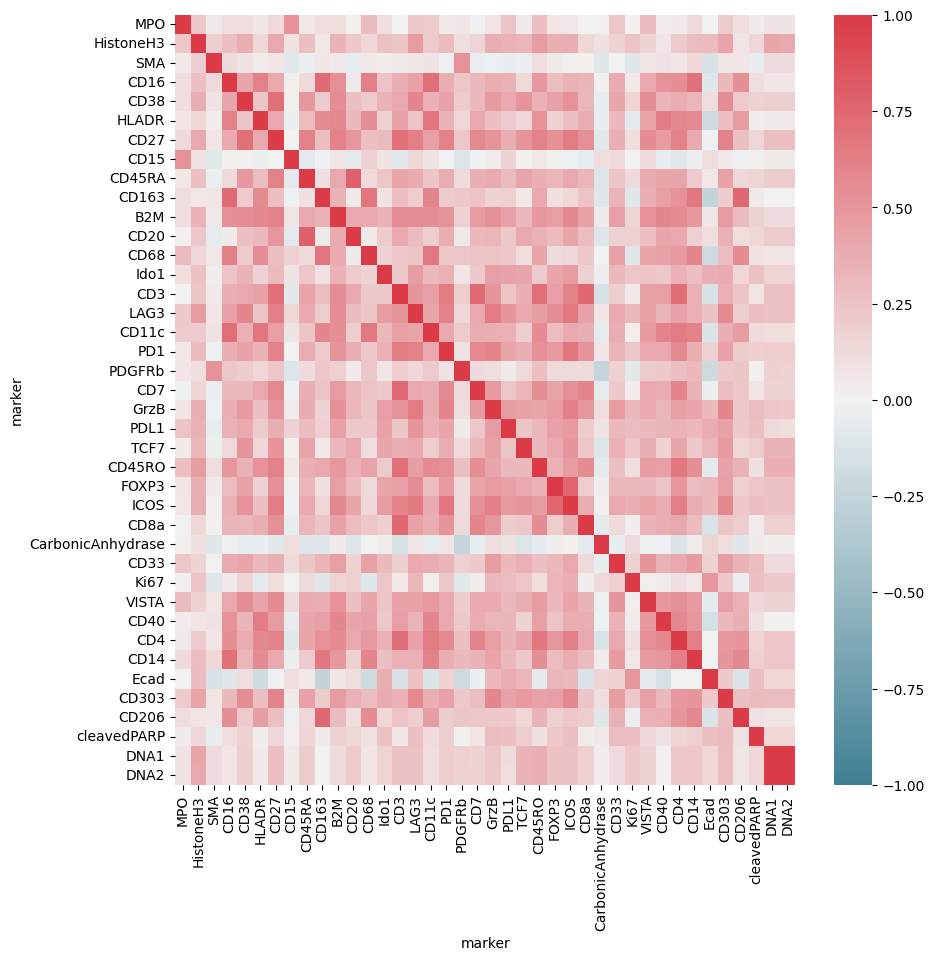

In [172]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(markers_corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            xticklabels=markers_corr.columns.values,
            yticklabels=markers_corr.columns.values,
            ax=ax)

In [173]:
from collections import defaultdict
from pathlib import Path
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from typing import List
import joblib

from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

import seaborn as sns
import json

In [174]:
tumor_data = all_data[all_data['celltypes'] == 'Tumor']

In [175]:
mac_data = all_data[all_data['celltypes'] == 'MacCD163']

In [ ]:
from sklearn.mixture import GaussianMixture

# Stwórz nowy DataFrame, usuń kolumny z markerami ekspresji
new_df = mac_data.drop(['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
                     'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
                     'CD11c', 'PDGFRb', 'CD7', 'GrzB', 'PD1', 'PDL1', 'TCF7', 'CD45RO',
                     'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
                     'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'cleavedPARP', 'DNA1',
                     'DNA2'], axis=1)

# Wybierz tylko kolumnę PD1
cd_data = mac_data[['CD206']]

# Przeprowadź dopasowanie modelu Gaussian Mixture
gmm = GaussianMixture(n_components=2, random_state=0).fit(cd_data)

# Przypisz etykiety klastrów do nowej kolumny w nowym DataFrame
new_df['CD206_label'] = gmm.predict(cd_data)

# Zamień etykiety klastrów na 0 i 1
new_df['CD206_label'] = new_df['CD206_label'].replace({0: 1, 1:0})

# Wyświetl nowy DataFrame
print(new_df)

                                                    index  \
0       IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
10      IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
20      IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
21      IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
22      IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
...                                                   ...   
234892  IMMUcan_Batch20220908_S-220729-00002_002.tiff_182   
235094  IMMUcan_Batch20220908_S-220729-00002_002.tiff_453   
236146  IMMUcan_Batch20220908_S-220729-00002_002.tiff_...   
236307  IMMUcan_Batch20220908_S-220729-00002_002.tiff_...   
236663  IMMUcan_Batch20220908_S-220729-00002_002.tiff_...   

                                                    image  \
0       IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
10      IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
20      IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...   
21      IMMUcan_batch20

<Axes: xlabel='CD206', ylabel='Count'>

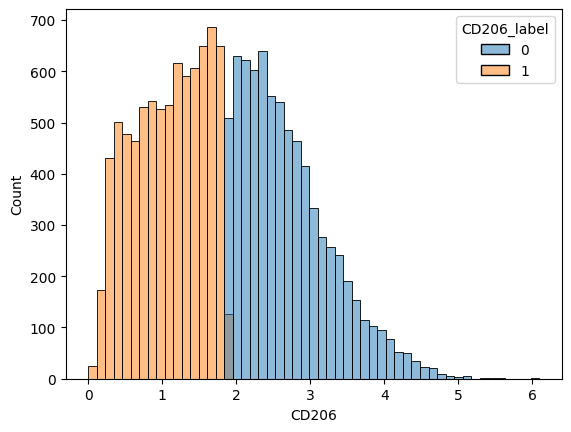

In [ ]:
sns.histplot(data=new_df, x="CD206", hue="CD206_label")

In [ ]:
exp_columns = ['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
                     'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
                     'CD11c', 'PD1', 'PDGFRb', 'CD7', 'GrzB', 'PDL1', 'TCF7', 'CD45RO',
                     'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
                     'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'cleavedPARP', 'DNA1',
                     'DNA2']

exp_tumor_data = tumor_data[exp_columns]
exp_tumor_data

,MPO,HistoneH3,SMA,CD16,CD38,HLADR,CD27,CD15,CD45RA,CD163,...,VISTA,CD40,CD4,CD14,Ecad,CD303,CD206,cleavedPARP,DNA1,DNA2
3,0.165905,1.144778,0.563216,1.166010,0.513735,2.034705,0.650242,0.250150,1.205007,0.990385,...,1.866916,1.228290,2.287524,2.491710,2.268924,0.196199,0.946492,0.233095,3.736089,4.368012
4,0.137497,2.210970,0.892371,0.497646,0.412840,1.499184,0.098131,0.208566,0.922874,1.255892,...,0.806346,0.360098,1.445085,2.332546,2.387292,0.061568,1.632904,0.372278,4.607359,5.152041
5,0.130002,0.763070,0.084880,0.578651,0.249627,1.608196,0.381839,0.017021,0.333893,0.376040,...,0.935827,0.683463,1.073085,2.031410,3.025615,0.000000,0.457221,0.147918,4.625445,5.103166
23,0.052607,1.732363,0.852566,0.356531,0.170076,0.610323,0.236015,0.114076,0.195641,0.270131,...,0.345455,0.320973,1.287706,1.078456,2.332815,0.000000,0.625975,0.072787,4.277741,4.800671
55,0.000000,0.881374,0.620422,0.668122,0.469823,0.171332,0.104139,0.000000,1.067393,0.442563,...,0.123265,0.363477,0.941620,0.912366,2.256495,0.228603,0.528715,0.094815,3.451175,4.061275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236777,0.310763,5.662029,0.000000,1.930384,1.266517,2.416677,1.454401,1.793315,1.153145,0.268418,...,0.497431,0.184777,0.576694,3.153904,3.747758,1.430592,0.300683,0.207754,4.082279,4.659309
236779,0.353124,6.343937,1.443070,2.764597,1.619617,2.128053,2.348564,1.730879,2.224251,1.011342,...,0.395083,0.168831,0.480288,2.089919,2.824779,1.327658,0.461557,0.342643,4.902707,5.419496
236780,0.516624,6.012589,1.134813,2.510355,1.547129,2.410669,1.999906,1.927906,1.809402,0.525357,...,0.468912,0.284126,1.046731,3.186178,3.962100,1.717256,0.317419,0.434471,4.541152,5.038857
236781,0.330040,6.170305,0.768679,2.526116,1.538002,2.536107,2.275608,1.753355,1.771835,0.943245,...,0.456508,0.300978,0.630578,3.101693,3.455742,1.647178,0.604681,0.201348,4.715174,5.193473


In [ ]:
markers_corr_tumor = exp_tumor_data.corr()

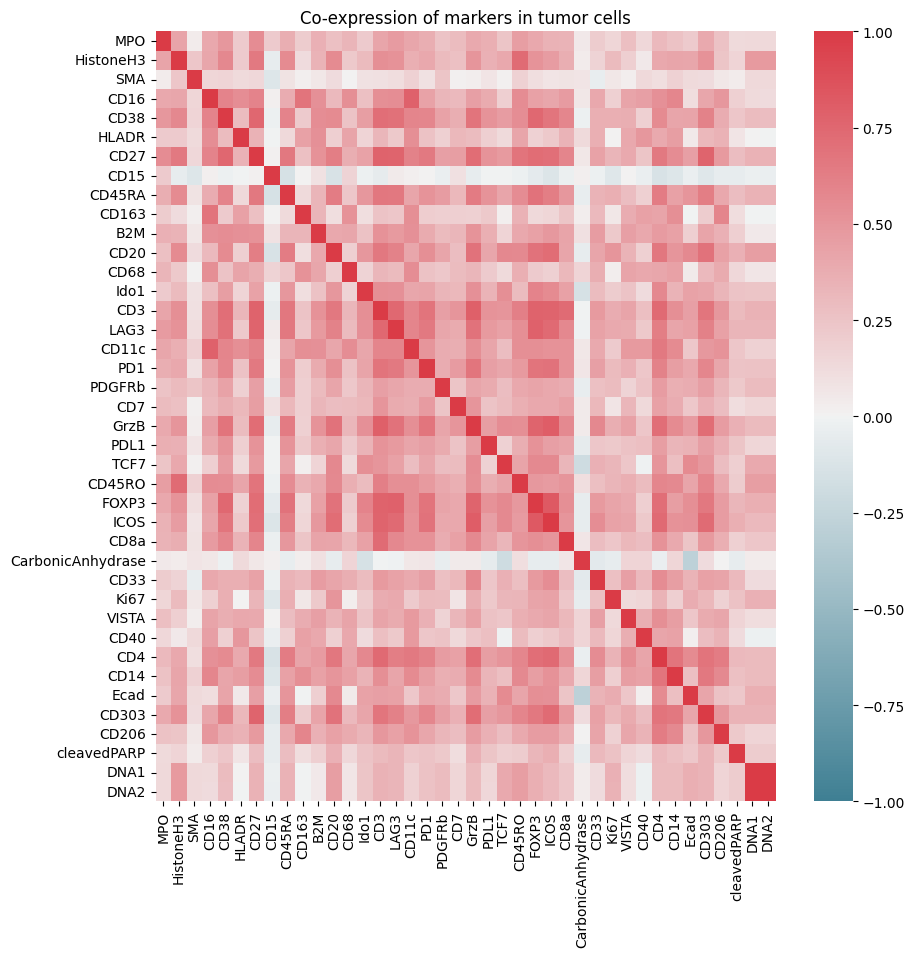

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(markers_corr_tumor,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            xticklabels=markers_corr_tumor.columns.values,
            yticklabels=markers_corr_tumor.columns.values,
            ax=ax)

ax.set_title('Co-expression of markers in tumor cells')  # Dodanie tytułu
plt.show()

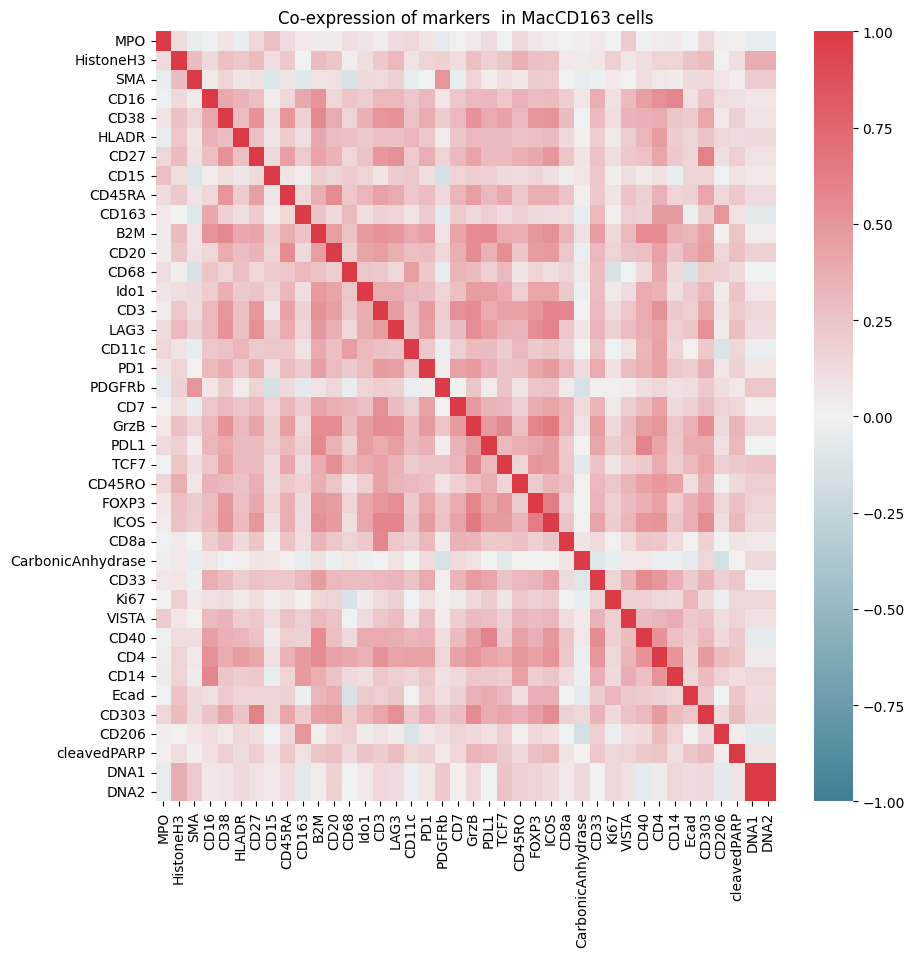

In [ ]:
exp_mac_data = mac_data[exp_columns]
exp_mac_data

markers_corr_mac = exp_mac_data.corr()


fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(markers_corr_mac,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            xticklabels=markers_corr_mac.columns.values,
            yticklabels=markers_corr_mac.columns.values,
            ax=ax)
ax.set_title('Co-expression of markers  in MacCD163 cells')  # Dodanie tytułu
plt.show()

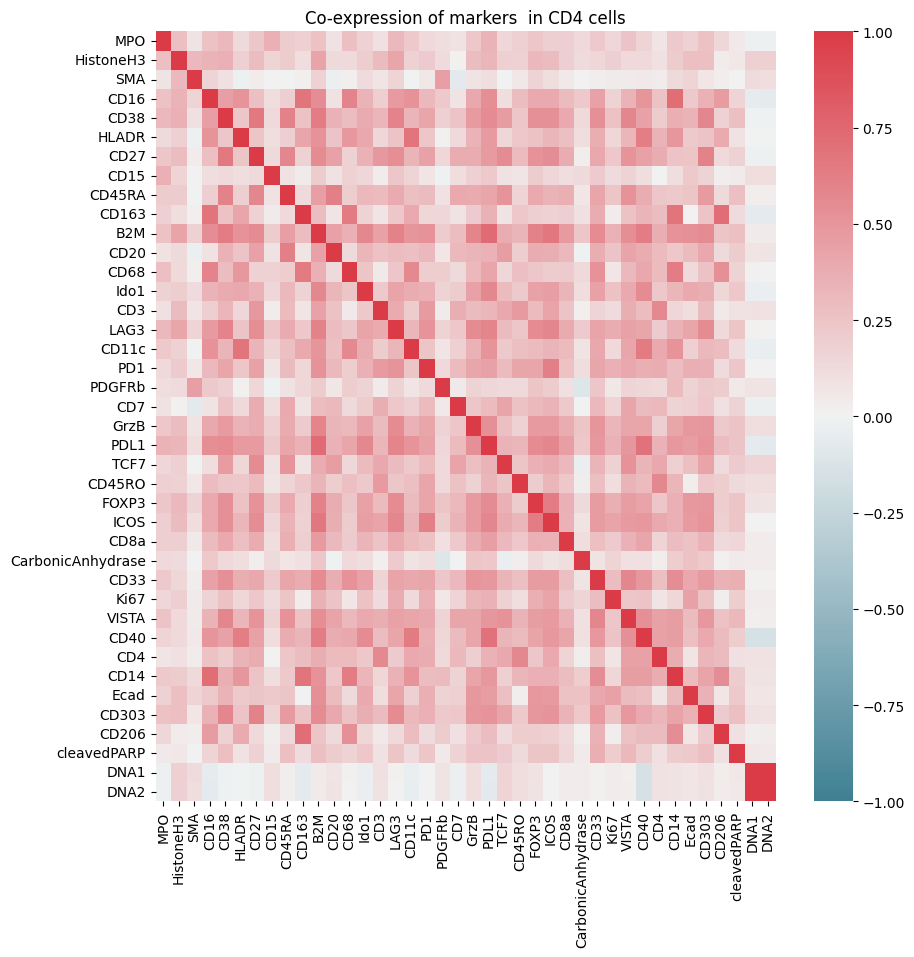

In [ ]:
cd4_data = all_data[all_data['celltypes'] == 'CD4']

exp_cd4_data = cd4_data[exp_columns]
exp_cd4_data

markers_corr_cd4 = exp_cd4_data.corr()


fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(markers_corr_cd4,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            xticklabels=markers_corr_cd4.columns.values,
            yticklabels=markers_corr_cd4.columns.values,
            ax=ax)
ax.set_title('Co-expression of markers  in CD4 cells')  # Dodanie tytułu
plt.show()

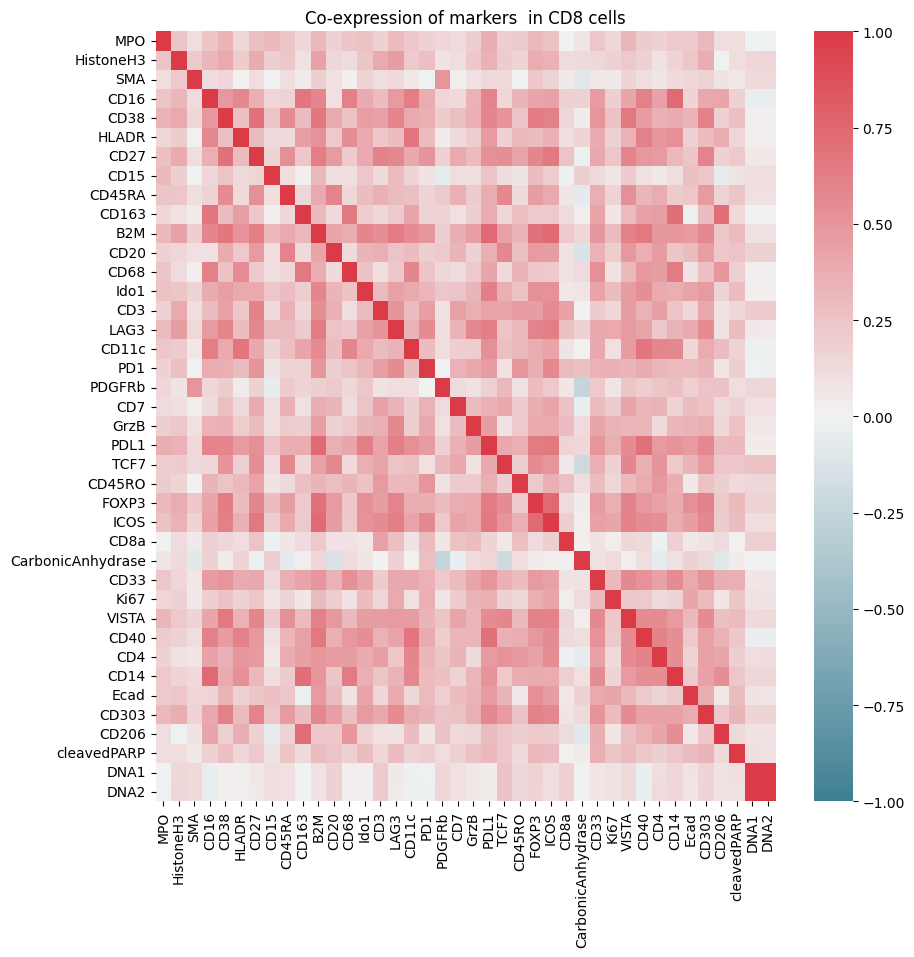

In [ ]:
cd8_data = all_data[all_data['celltypes'] == 'CD8']

exp_cd8_data = cd8_data[exp_columns]
exp_cd8_data

markers_corr_cd8 = exp_cd8_data.corr()


fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(markers_corr_cd8,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            xticklabels=markers_corr_cd8.columns.values,
            yticklabels=markers_corr_cd8.columns.values,
            ax=ax)
ax.set_title('Co-expression of markers  in CD8 cells')  # Dodanie tytułu
plt.show()

In [208]:
from sklearn.mixture import GaussianMixture

# Stwórz nowy DataFrame, usuń kolumny z markerami ekspresji
# patterns_tumor = tumor_data.drop(['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
#                      'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
#                      'CD11c', 'PDGFRb', 'CD7', 'GrzB', 'PD1', 'TCF7', 'CD45RO',
#                      'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'VISTA',
#                      'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'DNA1',
#                      'DNA2'], axis=1)

# Przeprowadź dopasowanie modelu Gaussian Mixture
def add_labels(markers, data):
  for marker in markers:
    print(marker)
    gmm = GaussianMixture(n_components=2, random_state=0).fit(data[[marker]])
    label = marker + '_LABEL'
    data[label] = gmm.predict(data[[marker]])

    val_1 = data.loc[data[label] == 1, marker].iloc[0]
    val_0 = data.loc[data[label] == 0, marker].iloc[0]

    if val_1 < val_0:
      data[label] = data[label].replace({0: 1, 1: 0})

# def assign_label(row):
#   if row["result"]==0:
#     value = f"{row['celltypes']}_-"
#   else:
#     value = f"{row['celltypes']}_+"
#   return value


# def add_labels(data, markers):
#   output = data.copy()
#   for marker in markers:
#     gmm = GaussianMixture(n_components=2, random_state=0).fit(data[[marker]])
#     data["result"] = gmm.predict(data[[marker]])

#     val_1 = data.loc[data["result"] == 1, marker].iloc[0]
#     val_0 = data.loc[data["result"] == 0, marker].iloc[0]

#     if val_1 < val_0:
#       data["result"] = data["result"].replace({0: 1, 1: 0})


#     data["new_celltype"] = data.apply(assign_label, axis=1)
#     pd.concat([output, data], axis=1)

#   return output



markers = ['PDL1', 'Ki67', 'cleavedPARP']

add_labels(markers, tumor_data)

PDL1
Ki67


<ipython-input-208-a6c802ffef08>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[label] = gmm.predict(data[[marker]])
<ipython-input-208-a6c802ffef08>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[label] = data[label].replace({0: 1, 1: 0})
<ipython-input-208-a6c802ffef08>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

cleavedPARP


<ipython-input-208-a6c802ffef08>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[label] = gmm.predict(data[[marker]])


,index,image,sample_id,ObjectNumber,Pos_X,Pos_Y,area,major_axis_length,minor_axis_length,eccentricity,...,CD303,CD206,cleavedPARP,DNA1,DNA2,result,new_celltype,PDL1_LABEL,Ki67_LABEL,cleavedPARP_LABEL
3,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,7.0,431.916667,0.750000,12.0,5.294329,2.862220,0.841267,...,0.196199,0.946492,0.233095,3.736089,4.368012,0,Tumor_-,0,0,0
4,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,8.0,116.931034,1.206897,29.0,9.216670,4.112503,0.894932,...,0.061568,1.632904,0.372278,4.607359,5.152041,0,Tumor_-,0,0,0
5,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,12.0,437.920000,1.320000,25.0,7.590327,4.176858,0.834976,...,0.000000,0.457221,0.147918,4.625445,5.103166,0,Tumor_-,0,0,0
23,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,87.0,46.000000,20.684211,19.0,6.184666,3.966521,0.767250,...,0.000000,0.625975,0.072787,4.277741,4.800671,0,Tumor_-,0,0,0
55,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01...,273.0,185.125000,66.875000,8.0,3.464102,2.738613,0.612372,...,0.228603,0.528715,0.094815,3.451175,4.061275,0,Tumor_-,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236777,IMMUcan_Batch20220908_S-220729-00002_002.tiff_...,IMMUcan_Batch20220908_S-220729-00002_002.tiff,IMMUcan_Batch20220908_S-220729-00002_002,2695.0,564.157895,590.842105,19.0,5.271572,4.500539,0.520704,...,1.430592,0.300683,0.207754,4.082279,4.659309,0,Tumor_-,0,0,0
236779,IMMUcan_Batch20220908_S-220729-00002_002.tiff_...,IMMUcan_Batch20220908_S-220729-00002_002.tiff,IMMUcan_Batch20220908_S-220729-00002_002,2705.0,576.190476,593.500000,42.0,8.362183,6.397028,0.644036,...,1.327658,0.461557,0.342643,4.902707,5.419496,0,Tumor_-,0,1,0
236780,IMMUcan_Batch20220908_S-220729-00002_002.tiff_...,IMMUcan_Batch20220908_S-220729-00002_002.tiff,IMMUcan_Batch20220908_S-220729-00002_002,2706.0,557.684211,593.763158,76.0,10.899195,8.919450,0.574708,...,1.717256,0.317419,0.434471,4.541152,5.038857,0,Tumor_-,0,0,0
236781,IMMUcan_Batch20220908_S-220729-00002_002.tiff_...,IMMUcan_Batch20220908_S-220729-00002_002.tiff,IMMUcan_Batch20220908_S-220729-00002_002,2707.0,570.470588,594.882353,34.0,8.469333,5.555055,0.754846,...,1.647178,0.604681,0.201348,4.715174,5.193473,0,Tumor_-,0,1,0


<Axes: xlabel='PDL1', ylabel='Count'>

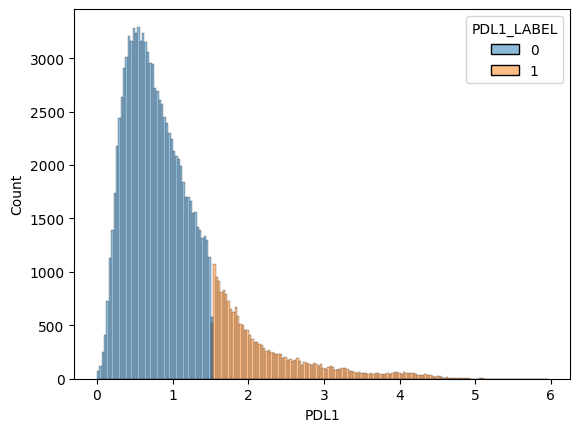

In [209]:
sns.histplot(data=tumor_data, x="PDL1", hue="PDL1_LABEL")

<Axes: xlabel='Ki67', ylabel='Count'>

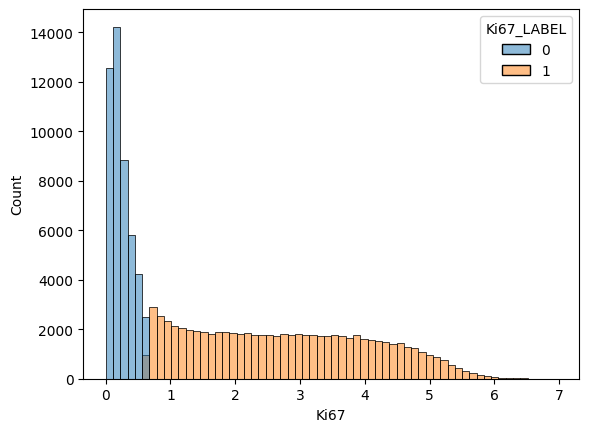

In [211]:
sns.histplot(data=tumor_data, x="Ki67", hue="Ki67_LABEL")

<Axes: xlabel='cleavedPARP', ylabel='Count'>

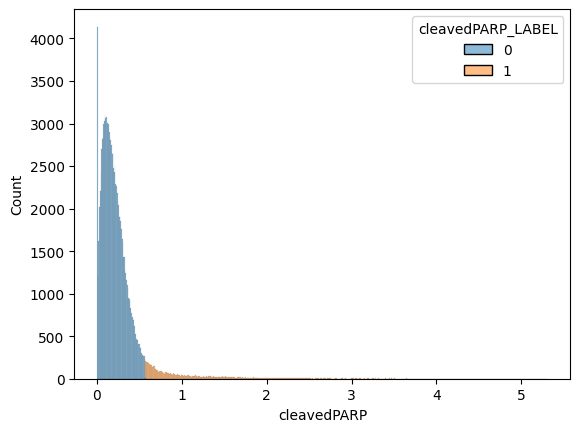

In [210]:
sns.histplot(data=tumor_data, x="cleavedPARP", hue="cleavedPARP_LABEL")

In [212]:
add_labels(["CD206"], mac_data)

CD206


<ipython-input-208-a6c802ffef08>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[label] = gmm.predict(data[[marker]])


<Axes: xlabel='CD206', ylabel='Count'>

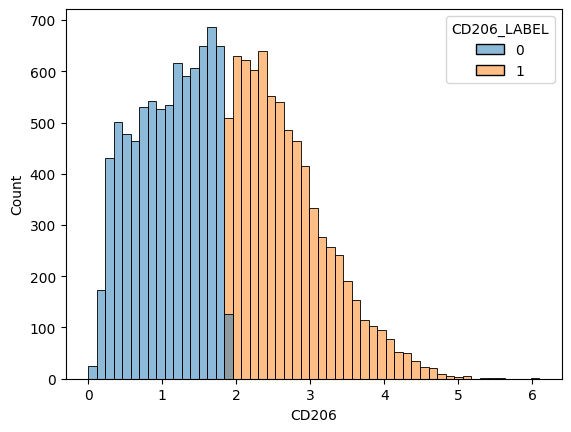

In [213]:
sns.histplot(data=mac_data, x="CD206", hue="CD206_LABEL")

In [214]:
tumor_data.columns

Index(['index', 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area',
       'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px',
       'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description',
       'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI',
       'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI',
       'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes',
       'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos',
       'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels',
       'MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
       'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
       'CD11c', 'PD1', 'PDGFRb', 'CD7', 'GrzB', 'PDL1', 'TCF7', 'CD45RO',
       'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
       'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'cleavedPARP', 'DNA1',
       'DNA

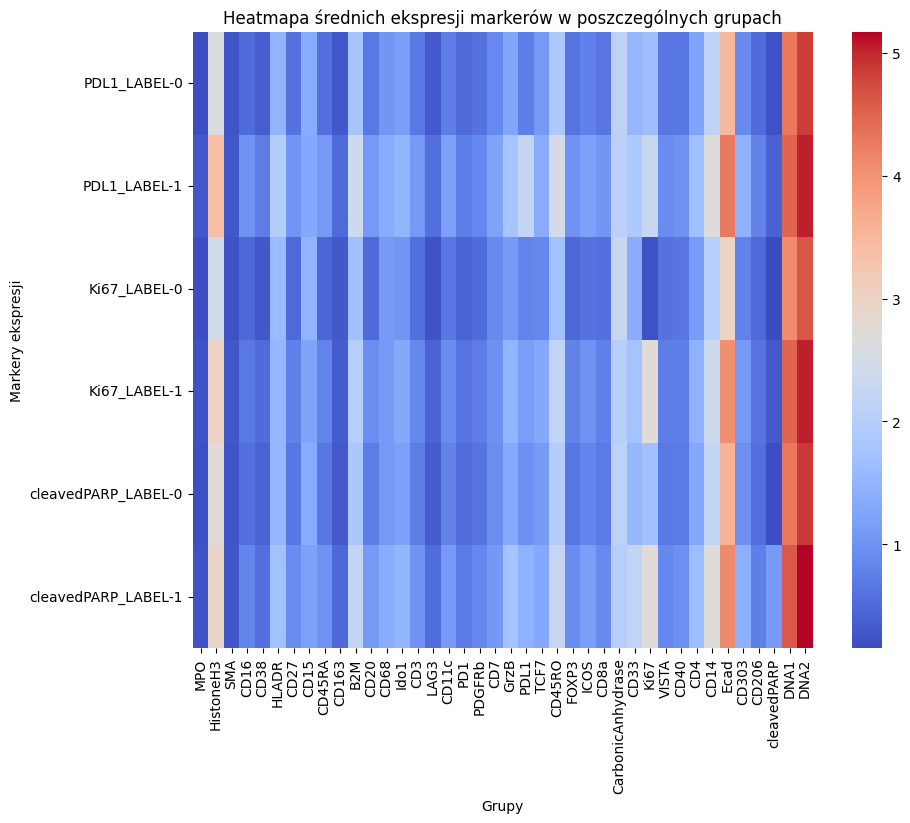

In [217]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dane wejściowe
markers = ['MPO', 'HistoneH3', 'SMA', 'CD16', 'CD38', 'HLADR', 'CD27', 'CD15',
           'CD45RA', 'CD163', 'B2M', 'CD20', 'CD68', 'Ido1', 'CD3', 'LAG3',
           'CD11c', 'PD1', 'PDGFRb', 'CD7', 'GrzB', 'PDL1', 'TCF7', 'CD45RO',
           'FOXP3', 'ICOS', 'CD8a', 'CarbonicAnhydrase', 'CD33', 'Ki67', 'VISTA',
           'CD40', 'CD4', 'CD14', 'Ecad', 'CD303', 'CD206', 'cleavedPARP', 'DNA1',
           'DNA2']
labels = ['PDL1_LABEL', 'Ki67_LABEL', 'cleavedPARP_LABEL']

# Obliczenie średnich ekspresji dla każdego markera w poszczególnych grupach
mean_expressions = {}
for label in labels:
    label_grouped = tumor_data.groupby(label)
    label_means = label_grouped[markers].mean()
    mean_expressions[label] = label_means

# Stworzenie DataFrame'a na podstawie średnich ekspresji
mean_expressions_df = pd.concat(mean_expressions.values(), keys=mean_expressions.keys())

# Stworzenie heatmapy
plt.figure(figsize=(10, 8))
sns.heatmap(mean_expressions_df, cmap="coolwarm", annot=False, fmt=".2f")
plt.title('Heatmapa średnich ekspresji markerów w poszczególnych grupach')
plt.xlabel('Grupy')
plt.ylabel('Markery ekspresji')
plt.show()


In [220]:
mean_expressions_df.T

PDL1_LABEL           Ki67_LABEL           cleavedPARP_LABEL  \
PDL1_LABEL                 0         1          0         1                 0   
MPO                 0.194077  0.290635   0.189368  0.224791          0.208107   
HistoneH3           2.635814  3.375247   2.438110  2.977178          2.752033   
SMA                 0.261884  0.295570   0.233559  0.290124          0.267379   
CD16                0.522141  1.001212   0.484195  0.684102          0.588816   
CD38                0.362595  0.719968   0.282154  0.517654          0.414316   
HLADR               1.470266  1.977313   1.593546  1.534339          1.546985   
CD27                0.590489  1.032670   0.509973  0.769858          0.649305   
CD15                1.339361  1.303270   1.479156  1.237223          1.343819   
CD45RA              0.586716  1.096631   0.466868  0.811291          0.652519   
CD163               0.296132  0.500908   0.299661  0.352391          0.320958   
B2M                 1.778522  2.371801   1.681777  2.011771          1.858440   
CD20                0.687501  1.091673   0.496490  0.928568          0.732351   
CD68                1.050377  1.340088   1.102223  1.099197          1.082185   
Ido1                1.144095  1.505231   1.056380  1.305008          1.185033   
CD3                 0.670359  1.093342   0.568542  0.858226          0.725168   
LAG3                0.320080  0.568385   0.248778  0.437937          0.349596   
CD11c               0.730538  1.192447   0.667707  0.903934          0.790181   
PD1                 0.498563  0.749155   0.436799  0.610811          0.531198   
PDGFRb              0.594002  0.848175   0.511523  0.720879          0.622441   
CD7                 0.874583  1.224401   0.883286  0.968933          0.925229   
GrzB                1.263457  1.778887   1.115684  1.507951          1.323448   
PDL1                0.756636  2.228421   0.816007  1.138649          0.978316   
TCF7                1.081866  1.337096   0.857315  1.302356          1.113870   
CD45RO              1.898704  2.496906   1.712989  2.191794          1.982833   
FOXP3               0.611914  0.987068   0.489985  0.799308          0.660128   
ICOS                0.766689  1.176964   0.596019  0.996142          0.813553   
CD8a                0.628801  1.052105   0.581065  0.781240          0.687955   
CarbonicAnhydrase   2.116739  2.071873   2.269621  2.003494          2.115660   
CD33                1.532117  1.886626   1.353062  1.751126          1.552946   
Ki67                1.646454  2.287369   0.236892  2.755564          1.687086   
VISTA               0.635886  0.912160   0.603917  0.735911          0.671424   
CD40                0.649117  1.010572   0.637545  0.760112          0.692654   
CD4                 1.252643  1.705024   1.121582  1.468125          1.308349   
CD14                2.122757  2.698626   2.017591  2.356555          2.186775   
Ecad                3.479604  4.281071   2.957768  4.051597          3.583043   
CD303               0.892934  1.436763   0.796450  1.111866          0.956865   
CD206               0.530730  0.800371   0.500233  0.627891          0.563922   
cleavedPARP         0.226775  0.396511   0.159153  0.319741          0.194332   
DNA1                4.292290  4.485490   4.076547  4.489252          4.305416   
DNA2                4.853510  5.043981   4.636762  5.050351          4.866154   

                             
PDL1_LABEL                1  
MPO                0.247589  
HistoneH3          2.923148  
SMA                0.272186  
CD16               0.828563  
CD38               0.563515  
HLADR              1.708799  
CD27               0.911318  
CD15               1.184048  
CD45RA             0.984897  
CD163              0.478358  
B2M                2.194979  
CD20               1.105035  
CD68               1.354403  
Ido1               1.505120  
CD3                0.997531  
LAG3               0.549221  
CD11c              1.090741  
PD1                0.690101  
PDGFRb         

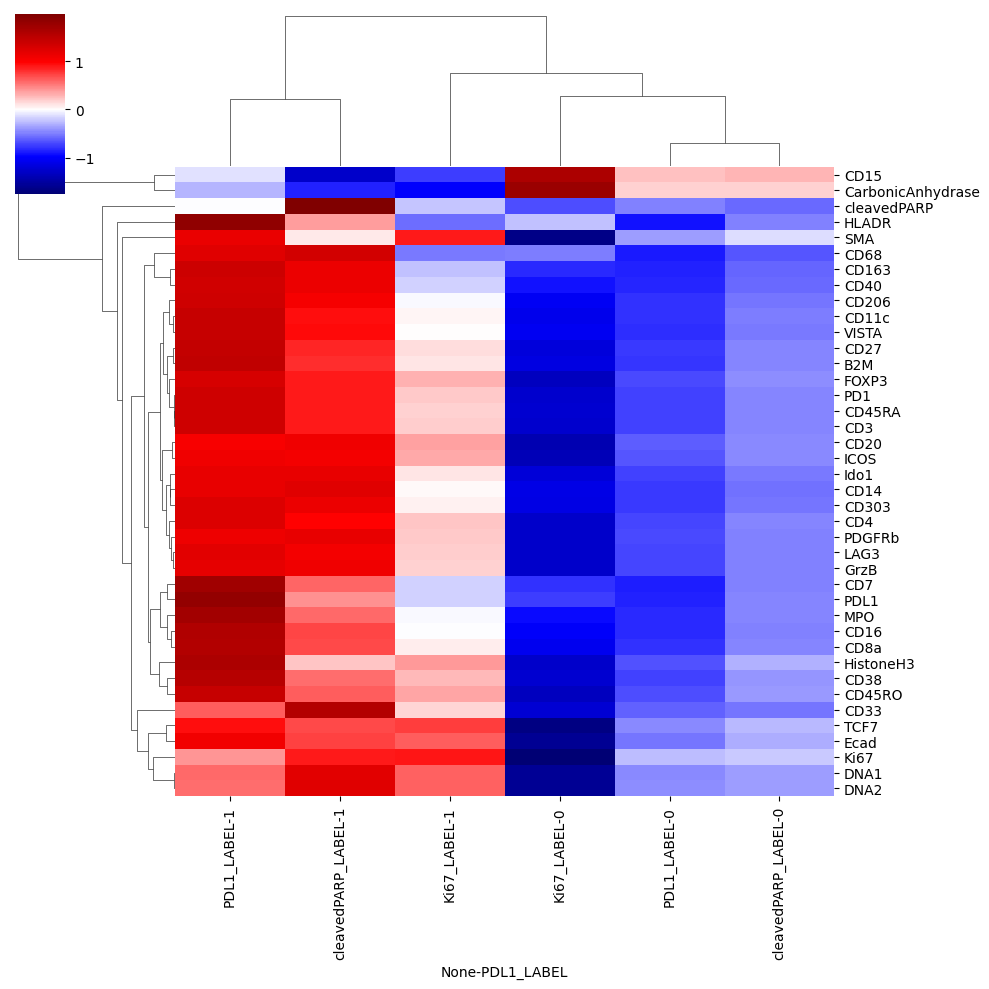

In [227]:
sns.clustermap(mean_expressions_df.T, z_score=0, center=0, yticklabels=mean_expressions_df.columns, cmap="seismic")

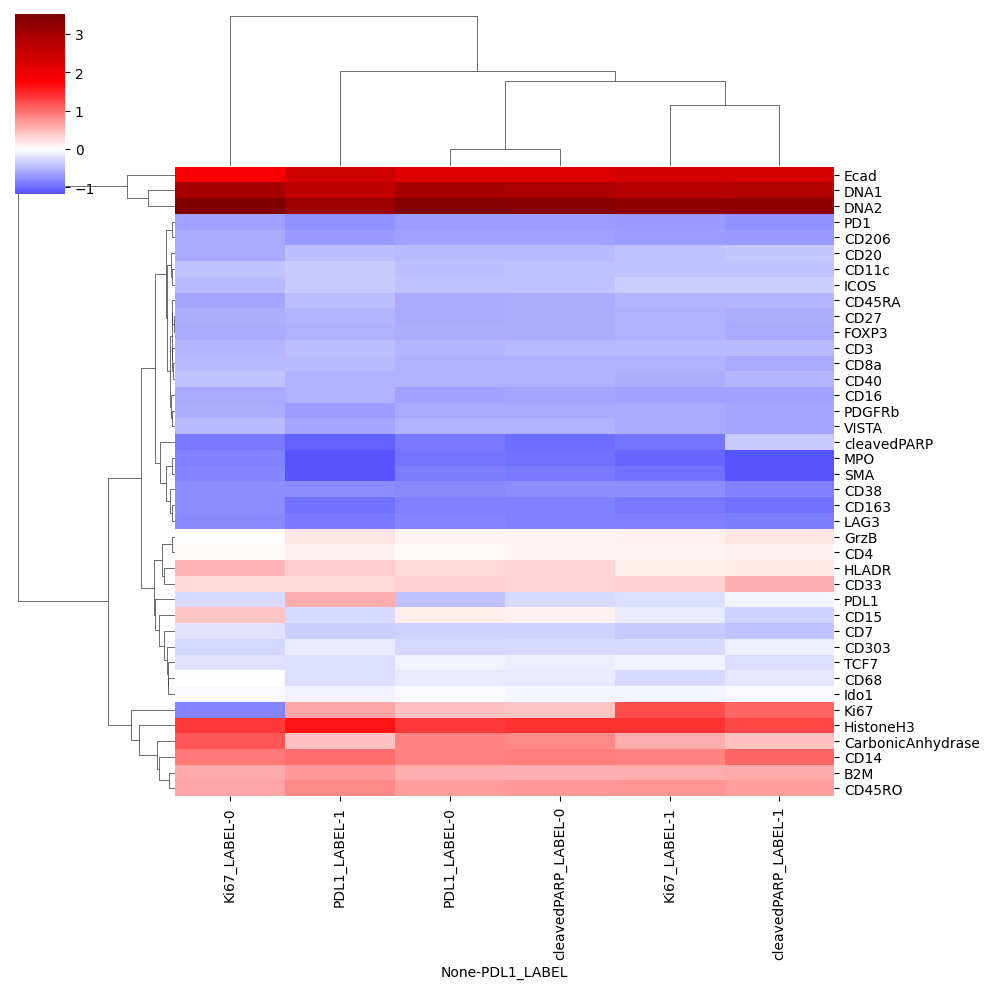

In [228]:
sns.clustermap(mean_expressions_df.T, z_score=1, center=0, yticklabels=mean_expressions_df.columns, cmap="seismic")